# Importing Census Data

In [2]:
import requests
import pandas as pd
from census import Census
from api_keys import api_key
import matplotlib.pyplot as plt
from scipy import stats
from unidecode import unidecode
from scipy.stats import linregress
import seaborn as sns
import plotly.express as px
import pygwalker as pyg
import re
import numpy as np
import statsmodels.api as sm
from scipy.stats import linregress
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression

In [3]:
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]  # You can add more years here

dsource = 'acs'
dname = 'acs1'

cols = 'NAME,B25077_001E,B25058_001E,B15003_022E,B01003_001E,B23025_004E,B17001_002E,B23025_003E,B19013_001E,B25003_003E,B25003_001E'  

state_fips_codes = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56','72']  

all_data = []

# Loop through each year
for year in years:
    
    # Loop through all states to fetch data for all counties
    for state in state_fips_codes:
        
        data_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}?get={cols}&for=county:*&in=state:{state}&key={api_key}'
              
        response = requests.get(data_url)
        
        # Check if the request was successful (200 indicates request was successfully processed)
        if response.status_code == 200:
            # Parse the response JSON data
         data = response.json()
            
        # Create a DataFrame from the response data
         df = pd.DataFrame(data[1:], columns=data[0])  # Skip the header row
            
        # Rename columns
         df = df.rename(columns={
                'NAME': 'County Name',
                'state': 'State FIPS',
                'county': 'County FIPS',
                'B25077_001E': 'Median House Price ($)',
                'B25058_001E': 'Median Rent ($)',
                'B01003_001E': 'Total Population',
                'B15003_022E': 'Population with Bachelor\'s Degree',
                'B23025_004E': 'Number of Employed People',
                'B17001_002E': 'People with Income Below Poverty',
                'B23025_003E': 'Total Labor Force',
                'B19013_001E' : 'Median Household Income ($)',
                'B25003_003E':'Owner Occupied Housing Units',
                'B25003_001E':'Total Households'
            })
            
        # Add a column for the year
         df['Year'] = year
                   
         all_data.append(df)
        else:
            print(f"Error: {response.status_code} for State: {state} in Year: {year}")

# Concatenate all data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)



In [4]:

# Convert columns to numeric, errors='coerce' will turn invalid values into NaN
numeric_columns = [
    'Median House Price ($)', 'Median Rent ($)', 'Total Population',
    'Population with Bachelor\'s Degree', 'Number of Employed People','Total Households',
    'People with Income Below Poverty', 'Total Labor Force','Median Household Income ($)','Owner Occupied Housing Units'
]

# Convert all columns to numeric
for col in numeric_columns:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

# Now print the min and max values, ignoring NaNs
print('Minimum Values:')
print(final_df.min())
print('---------------------------------------------------')
print('Maximum Values:')
print(final_df.max())

data_df = final_df.dropna()

# Check for missing values and data types
print('Number of Null Values in Each Column:')
print(data_df.isnull().sum())

# Removes Non-ASCII Characters
data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())
clean_data_df = final_df.dropna()

Minimum Values:
County Name                          Ada County, Idaho
Median House Price ($)                           49400
Median Rent ($)                                    229
Population with Bachelor's Degree               2306.0
Total Population                                 61792
Number of Employed People                        15513
People with Income Below Poverty                1432.0
Total Labor Force                                19658
Median Household Income ($)                      11940
Owner Occupied Housing Units                      2396
Total Households                                 16949
State FIPS                                          01
County FIPS                                        001
Year                                              2011
dtype: object
---------------------------------------------------
Maximum Values:
County Name                          Yuma County, Arizona
Median House Price ($)                            1233600
Median Rent ($) 

C:\Users\bansr\AppData\Local\Temp\ipykernel_35160\2990857478.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())


In [5]:
clean_data_df.to_csv('census_data_all.csv', index=False)

In [6]:
clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
clean_data_df['% People Living in Poverty'] = (clean_data_df['People with Income Below Poverty'] / clean_data_df['Total Population']) * 100
clean_data_df['% Pop. Bachelors Degree'] = clean_data_df['Population with Bachelor\'s Degree'] / clean_data_df['Total Population'] * 100

clean_data_df

C:\Users\bansr\AppData\Local\Temp\ipykernel_35160\999656447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
C:\Users\bansr\AppData\Local\Temp\ipykernel_35160\999656447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
C:\Users\bansr\AppData\Local

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,Total Households,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,74460,01,003,2011,4.784498,91.068052,12.972038,12.937761
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,44722,01,015,2011,5.037336,87.107572,20.663514,6.579115
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,31954,01,043,2011,4.392857,90.176552,18.302374,6.056919
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,27139,01,049,2011,4.461380,87.818876,18.484063,3.453590
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,28469,01,051,2011,3.860309,89.063651,12.161623,10.402685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,7574,28291,72,137,2019,5.162916,87.780156,38.193911,14.475367
7475,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,16578,47669,72,025,2019,4.462651,90.249694,38.401843,16.798549
7476,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,61677,138800,72,127,2019,3.464733,82.202677,39.230815,17.496491
7477,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,10768,33125,72,061,2019,3.654264,91.732293,22.813157,21.649866


In [7]:
#GROUPING ALL DATA BY COUNTIES
clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS'])
grouped_df.head()

C:\Users\bansr\AppData\Local\Temp\ipykernel_35160\4018136796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,Total Households,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree,Combined FIPS
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,74460,01,003,2011,4.784498,91.068052,12.972038,12.937761,00301
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,44722,01,015,2011,5.037336,87.107572,20.663514,6.579115,01501
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,31954,01,043,2011,4.392857,90.176552,18.302374,6.056919,04301
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,27139,01,049,2011,4.461380,87.818876,18.484063,3.453590,04901
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,28469,01,051,2011,3.860309,89.063651,12.161623,10.402685,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7151,"Franklin County, North Carolina",172700,633,8029.0,69685,33272,6025.0,36169,57099,7450,26720,37,069,2019,4.398379,91.990379,8.646050,11.521848,06937
7197,"Athens County, Ohio",145400,724,6432.0,65327,28943,15275.0,31442,41851,7747,22659,39,009,2019,5.975241,92.052032,23.382369,9.845852,00939
7288,"Kershaw County, South Carolina",146800,545,7227.0,66551,29374,9448.0,30909,55198,4576,24544,45,055,2019,4.455041,95.033809,14.196631,10.859341,05545
7344,"Wise County, Texas",243500,719,5985.0,69984,34650,3662.0,35396,71421,4001,22882,48,497,2019,3.543326,97.892417,5.232625,8.551955,49748


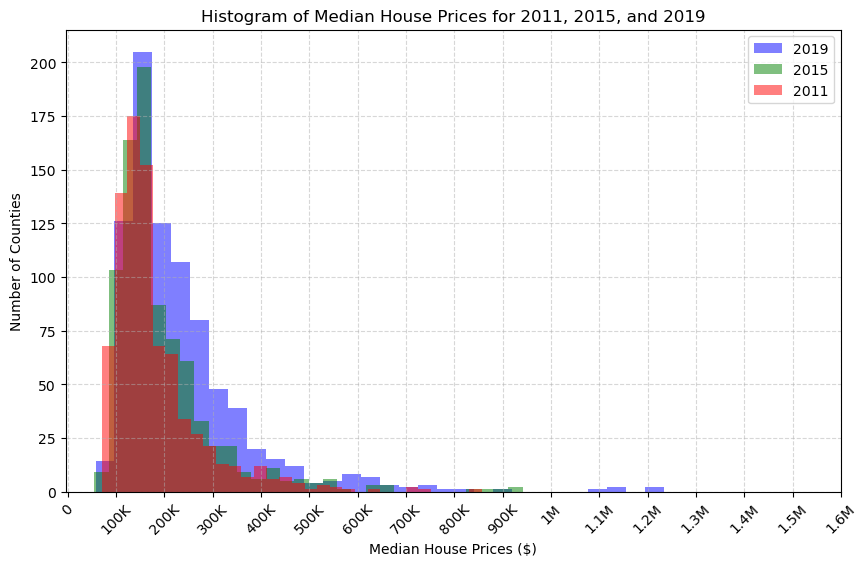

In [8]:
data_2011 = clean_data_df.loc[clean_data_df['Year'] == 2011]["Median House Price ($)"]
data_2015 = clean_data_df.loc[clean_data_df['Year'] == 2015]["Median House Price ($)"]
data_2019 = clean_data_df.loc[clean_data_df['Year'] == 2019]["Median House Price ($)"]

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(data_2019, bins=30, alpha=0.5, label='2019', color='blue')
plt.hist(data_2015, bins=30, alpha=0.5, label='2015', color='green')
plt.hist(data_2011, bins=30, alpha=0.5, label='2011', color='red')

# Adding titles and labels
plt.title('Histogram of Median House Prices for 2011, 2015, and 2019')
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')

# Define the ticks and labels
ticks = np.arange(0, 1700000, 100000)
labels = ['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M', '1.1M', '1.2M', '1.3M', '1.4M', '1.5M', '1.6M']

# Set the ticks and labels
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

# Display the plot
plt.show()

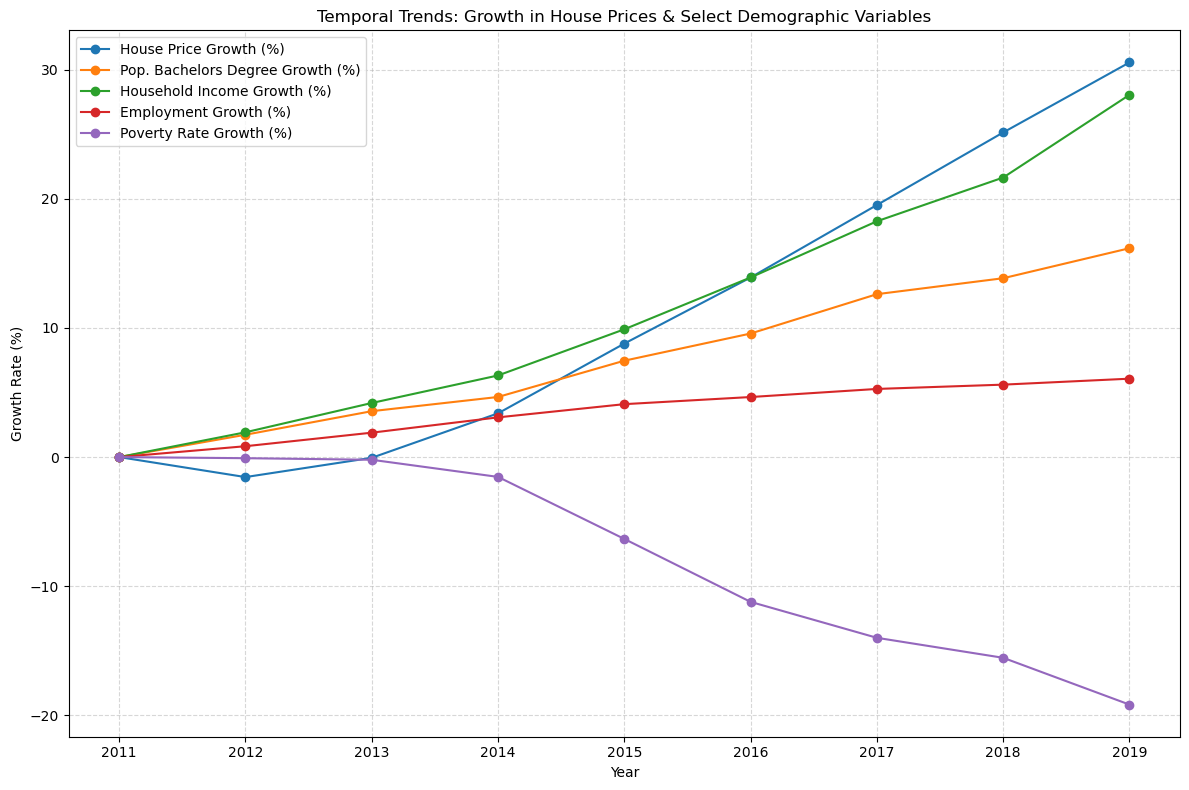

In [9]:
# Group data by year and calculate mean metrics
temporal_data = clean_data_df.groupby('Year').agg({
    'Median House Price ($)': 'mean',
    '% Pop. Bachelors Degree': 'mean',
    'Median House Price ($)': 'mean',
    'Median Household Income ($)': 'mean',
    'Employment Rate %': 'mean',
    '% People Living in Poverty': 'mean',
}).reset_index()

temporal_data['House Price Growth (%)'] = (
    (temporal_data['Median House Price ($)'] / temporal_data['Median House Price ($)'].iloc[0]) - 1) * 100

temporal_data['Pop. Bachelors Degree Growth (%)'] = (
    (temporal_data['% Pop. Bachelors Degree'] / temporal_data['% Pop. Bachelors Degree'].iloc[0]) - 1) * 100

temporal_data['Income Growth (%)'] = (
    (temporal_data['Median Household Income ($)'] / temporal_data['Median Household Income ($)'].iloc[0]) - 1) * 100

temporal_data['Employment Growth (%)'] = (
    (temporal_data['Employment Rate %'] / temporal_data['Employment Rate %'].iloc[0]) - 1) * 100

temporal_data['Poverty Rate Growth (%)'] = (
    (temporal_data['% People Living in Poverty'] / temporal_data['% People Living in Poverty'].iloc[0]) - 1) * 100




# Plot temporal trends
plt.figure(figsize=(12, 8))
plt.plot(temporal_data['Year'], temporal_data['House Price Growth (%)'], label='House Price Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Pop. Bachelors Degree Growth (%)'], label='Pop. Bachelors Degree Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Income Growth (%)'], label='Household Income Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Employment Growth (%)'], label='Employment Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Poverty Rate Growth (%)'], label='Poverty Rate Growth (%)', marker='o')
plt.title('Temporal Trends: Growth in House Prices, Income, and Employment Rates')
plt.title('Temporal Trends: Growth in House Prices & Select Demographic Variables')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# Save the figure as an image file
plt.savefig("temporal_trends_analysis.png", dpi=300, bbox_inches='tight')

# EDUCATIONAL ATTAINMENT AND HOME PRICES - STUDY

---------------- Results -----------------------------------------------
The slope of 18275.45 suggests that, on average, for every 1% increase in the population with a bachelor's degree, the median house price increases by $18275.45
The correlation between these variables is 0.6323720332830076 and the R-squared is 0.3998943884784853
The negative intercept of -18959.9 suggests that this analysis is not quite valid for small house prices and in counties with near-zero bachelor degree holders
THIS WILL CHANGE - The p-value of the correlation coefficient is 0.000
THIS WILL CHANGE - We conclude that the relationship between bot variables is medium in strengh, and that at least at third of the variability in prices can be captured by educational attainment
------------------------------------------------------------------------


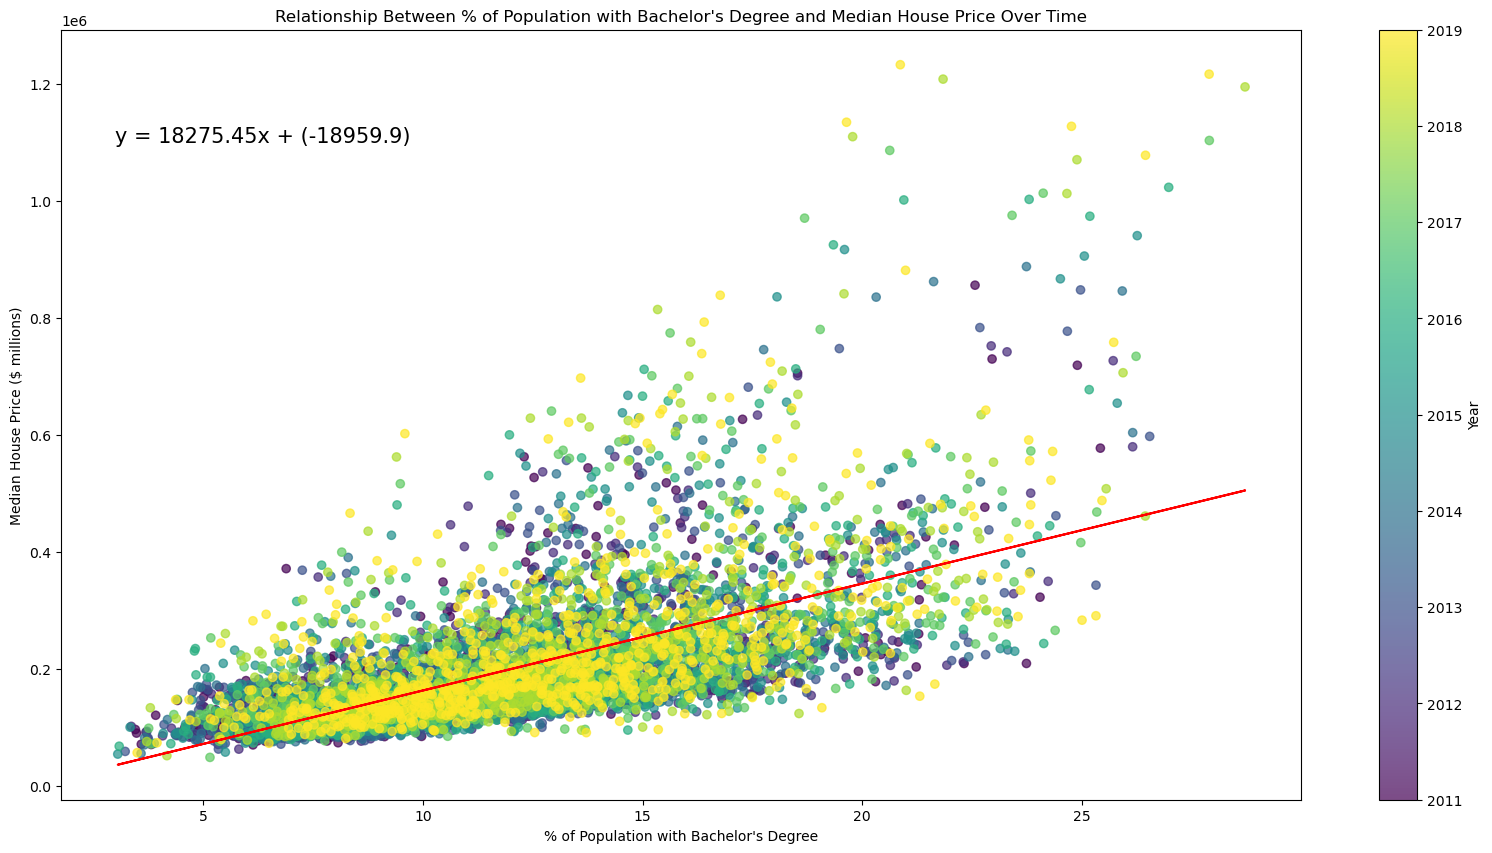

In [10]:
X = clean_data_df['% Pop. Bachelors Degree']
Y = clean_data_df['Median House Price ($)']

# Scatter plot with color-coded years
plt.figure(figsize=(20, 10))
scatter = plt.scatter(X, 
                      Y,
                      c=clean_data_df['Year'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Year')
plt.title('Relationship Between % of Population with Bachelor\'s Degree and Median House Price Over Time')
plt.xlabel('% of Population with Bachelor\'s Degree')
plt.ylabel('Median House Price ($ millions)')

(slope, intercept, rvalue, pvalue, stderr) = linregress(X, Y)
regress_values = X * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + (" +str(round(intercept,2))+ ")"
plt.plot(X,regress_values,"r-")
plt.annotate(line_eq, (3, 1100000),size=15)

print('---------------- Results -----------------------------------------------')
print(f'The slope of {slope:.2f} suggests that, on average, for every 1% increase in the population with a bachelor\'s degree, the median house price increases by ${slope:.2f}')
print(f'The correlation between these variables is {rvalue} and the R-squared is {(rvalue**2)}')
print(f'The negative intercept of {round(intercept, 2)} suggests that this analysis is not quite valid for small house prices and in counties with near-zero bachelor degree holders')
print(f'THIS WILL CHANGE - The p-value of the correlation coefficient is {pvalue:.3f}')
print(f'THIS WILL CHANGE - We conclude that the relationship between bot variables is medium in strengh, and that at least at third of the variability in prices can be captured by educational attainment')
print('------------------------------------------------------------------------')

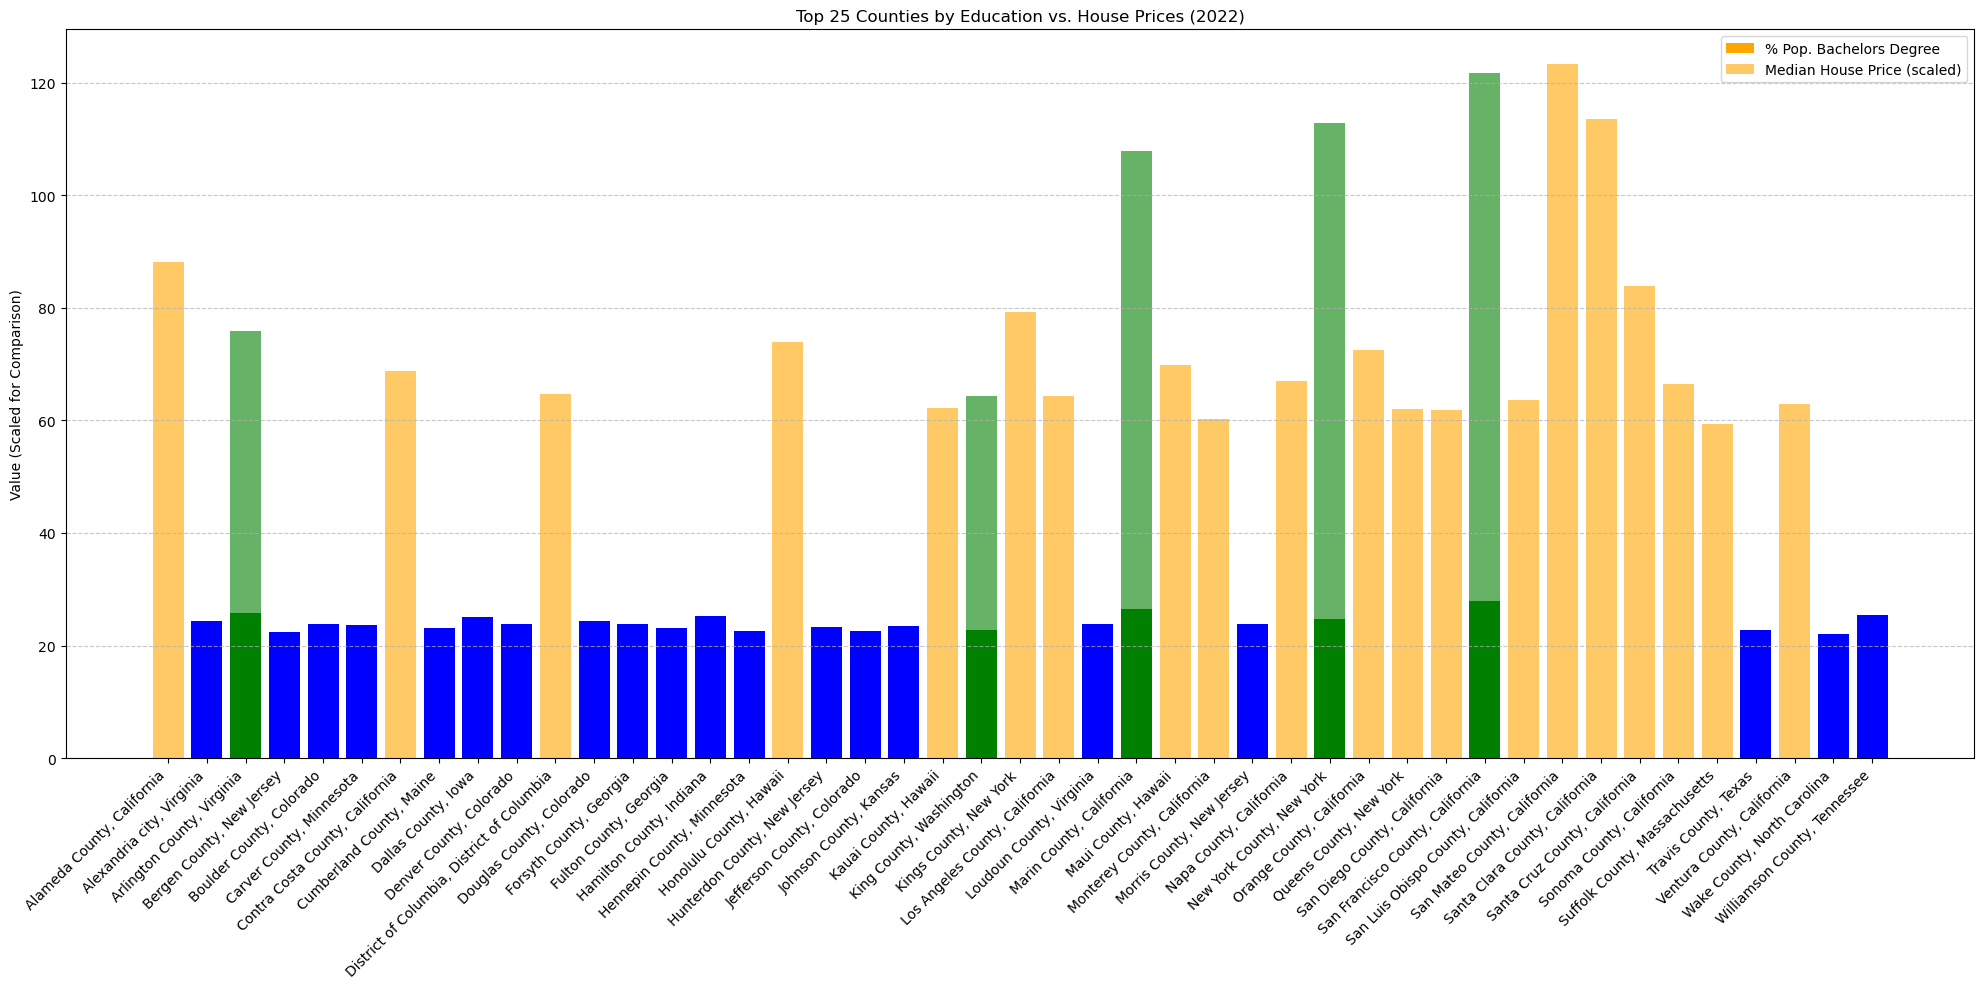

In [11]:
selected_year_data = clean_data_df[clean_data_df['Year'] == 2019]

# Top 10 counties by educational attainment
top_edu = selected_year_data.nlargest(25, '% Pop. Bachelors Degree')[['County Name', '% Pop. Bachelors Degree']].copy()
top_edu['List'] = 'Top Edu'

# Top 10 counties by median house price
top_price = selected_year_data.nlargest(25, 'Median House Price ($)')[['County Name', 'Median House Price ($)']].copy()
top_price['List'] = 'Top Price'

merged_top = pd.merge(top_edu, top_price, on='County Name', how='outer', indicator=True)

# Visualize overlap
plt.figure(figsize=(20, 10))
colors = merged_top['_merge'].map({'both': 'green', 'left_only': 'blue', 'right_only': 'orange'})
plt.bar(merged_top['County Name'], merged_top['% Pop. Bachelors Degree'], color=colors, label='% Pop. Bachelors Degree')
plt.bar(merged_top['County Name'], merged_top['Median House Price ($)'] / 10000, color=colors, alpha=0.6, label='Median House Price (scaled)')

# Customize
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (Scaled for Comparison)')
plt.title('Top 25 Counties by Education vs. House Prices (2022)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# T-TEST ON THE DIFFERENCE BETWEEN MEAN HOUSE PRICES FOR TOP AND BOTTOM COUNTIES

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS']).agg(
    avg_bachelor_degree=('% Pop. Bachelors Degree', 'mean'),
    avg_median_house_price=('Median House Price ($)', 'median')
).reset_index()

# Sort by educational attainment and select top 20% and bottom 20% counties
top_edu_counties = grouped_df.nlargest(int(len(grouped_df) * 0.25), 'avg_bachelor_degree')
bottom_edu_counties = grouped_df.nsmallest(int(len(grouped_df) * 0.25), 'avg_bachelor_degree')

# Extract the median house prices for each group
top_edu_prices = top_edu_counties['avg_median_house_price']
bottom_edu_prices = bottom_edu_counties['avg_median_house_price']

# Perform t-test
t_stat, p_value = stats.ttest_ind(top_edu_prices, bottom_edu_prices)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check if the p-value is less than 0.05 to conclude if there's a significant difference
if p_value < 0.05:
    print("There is a significant difference in median house prices between top and bottom educational attainment counties.")
else:
    print("There is no significant difference in median house prices between top and bottom educational attainment counties.")

T-statistic: 15.76392606893622
P-value: 2.8512205452456446e-44
There is a significant difference in median house prices between top and bottom educational attainment counties.


# INCOME AND HOME PRICES - STUDY

Linear Regression Statistics:
Slope: 5.15
Intercept: -90380.97
R: 0.71
R²: 0.51
P-value: 0.00e+00
Standard Error: 0.06


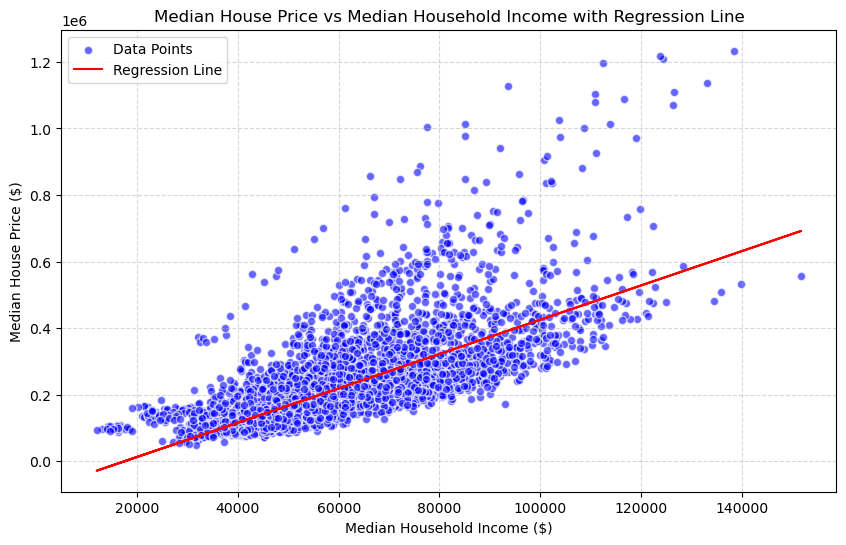

In [13]:
# with regression
# Prepare data for linear regression
X = data_df['Median Household Income ($)'].values.reshape(-1, 1)
y = data_df['Median House Price ($)'].values
# Create and fit the model
model = LinearRegression()
model.fit(X, y)
# Predict values for the regression line
y_pred = model.predict(X)
# Calculate regression statistics using scipy
slope, intercept, r_value, p_value, std_err = linregress(data_df['Median Household Income ($)'], data_df['Median House Price ($)'])
# Calculate R-squared value
r_squared = r_value**2
# Print linear regression statistics
print("Linear Regression Statistics:")
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"R: {r_value:.2f}")
print(f"R²: {r_squared:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"Standard Error: {std_err:.2f}")
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(
    data_df['Median Household Income ($)'],
    data_df['Median House Price ($)'],
    alpha=0.6,
    edgecolors='w',
    color='blue',
    label='Data Points'
)
plt.plot(data_df['Median Household Income ($)'], y_pred, color='red', label='Regression Line')
plt.title('Median House Price vs Median Household Income with Regression Line')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

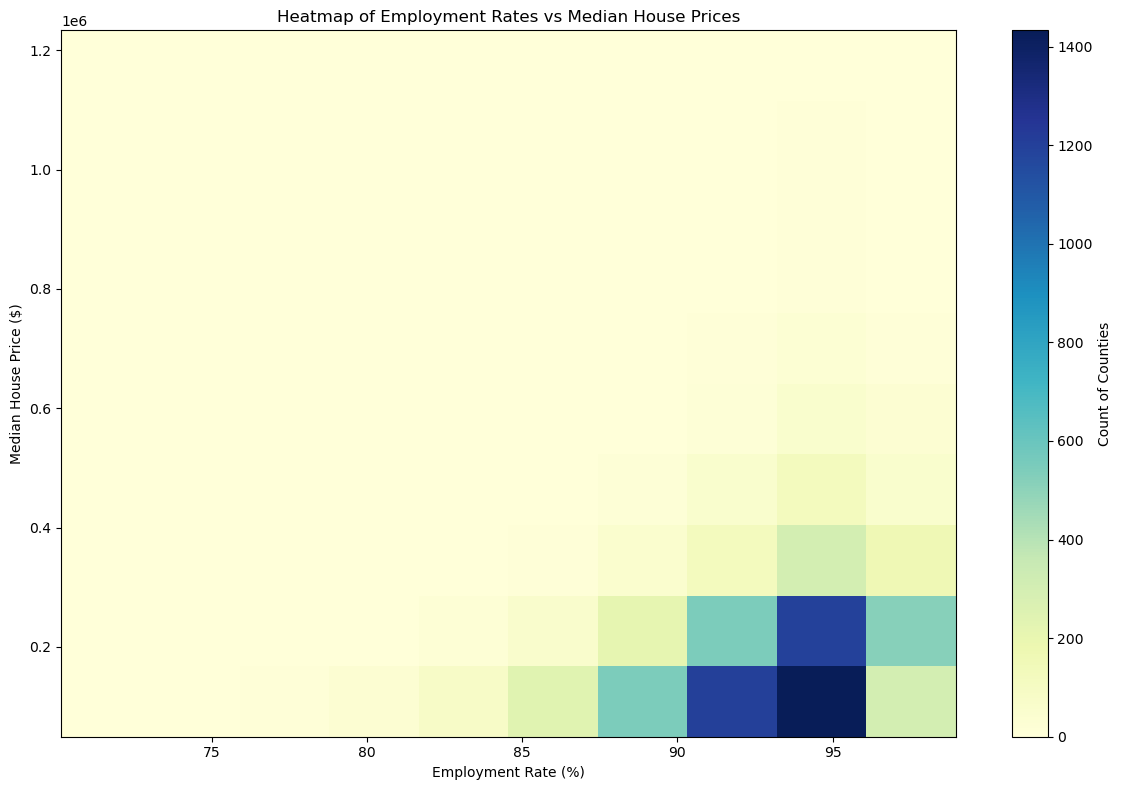

In [14]:
# Ensure data is loaded 
file_path = 'census_data_all.csv' 
census_data = pd.read_csv(file_path)

# Calculate Employment Rate if not already calculated
if 'Employment Rate (%)' not in census_data.columns:
    census_data['Employment Rate (%)'] = (
        (census_data['Number of Employed People'] / census_data['Total Labor Force']) * 100
    )

# Bin the data for employment rate and house price
employment_bins = pd.cut(census_data['Employment Rate (%)'], bins=10, labels=False)
house_price_bins = pd.cut(census_data['Median House Price ($)'], bins=10, labels=False)

# Create a 2D histogram
heatmap_data, xedges, yedges = np.histogram2d(
    census_data['Employment Rate (%)'], 
    census_data['Median House Price ($)'], 
    bins=[10, 10]
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data.T, origin='lower', cmap='YlGnBu', aspect='auto', extent=[
    min(census_data['Employment Rate (%)']),
    max(census_data['Employment Rate (%)']),
    min(census_data['Median House Price ($)']),
    max(census_data['Median House Price ($)']),
])
plt.colorbar(label='Count of Counties')
plt.title('Heatmap of Employment Rates vs Median House Prices')
plt.xlabel('Employment Rate (%)')
plt.ylabel('Median House Price ($)')
plt.tight_layout()
# Save the figure as an image file
plt.savefig("employment_rates_analysis.png", dpi=300, bbox_inches='tight')

plt.show()

# POVERTY AND HOME PRICES - STUDY

Logarithmic Regression Equation: y = -119042.84 ln(x) + 506061.41
r-value (Correlation Coefficient): -0.44
r^2-value (Coefficient of Determination): 0.19
p-value: 0.0000
Standard Error: 2819.66


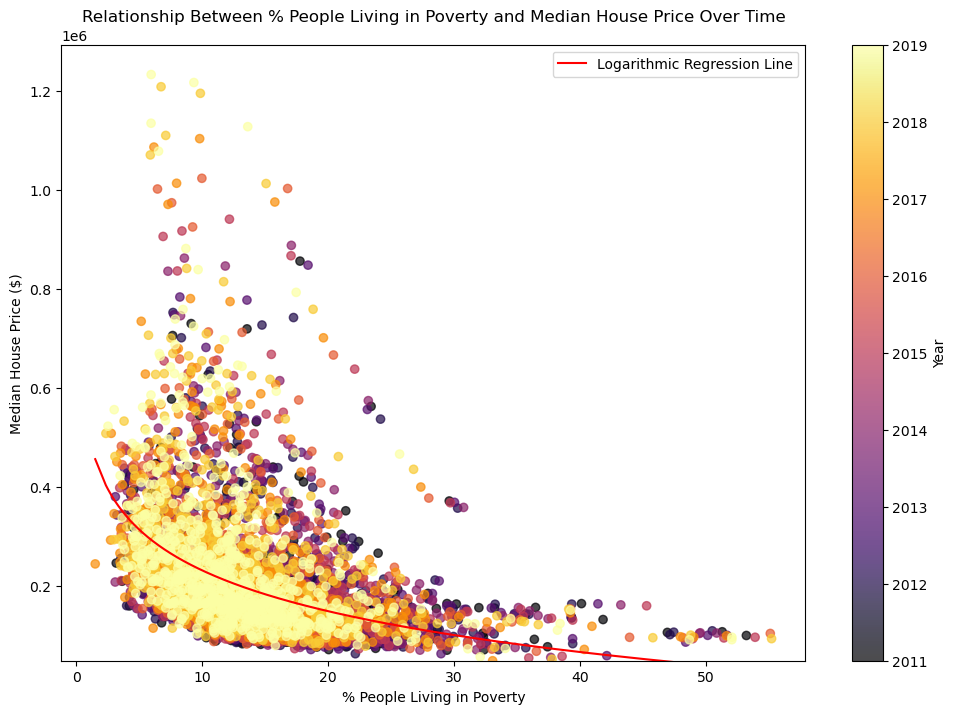

In [15]:
clean_data_df.reset_index(drop=True, inplace=True)
clean_data_df = clean_data_df[clean_data_df['Median House Price ($)'] > 10000]

# Variables for regression
X = clean_data_df['% People Living in Poverty']
Y = clean_data_df['Median House Price ($)']

# Transform the X variable using the natural logarithm
log_X = np.log(X)

# Perform logarithmic regression
slope, intercept, rvalue, pvalue, stderr = linregress(log_X, Y)

# Calculate r^2 value
r_squared = rvalue**2

# Predict values for plotting
log_reg_predict = log_X * slope + intercept

# Display regression metrics
print(f'Logarithmic Regression Equation: y = {slope:.2f} ln(x) + {intercept:.2f}')
print(f'r-value (Correlation Coefficient): {rvalue:.2f}')
print(f'r^2-value (Coefficient of Determination): {r_squared:.2f}')
print(f'p-value: {pvalue:.4f}')
print(f'Standard Error: {stderr:.2f}')

# Scatter plot 
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X, Y, c=clean_data_df['Year'], cmap="inferno", alpha=0.7)
plt.colorbar(scatter, label='Year')
plt.title('Relationship Between % People Living in Poverty and Median House Price Over Time')
plt.xlabel('% People Living in Poverty')
plt.ylabel('Median House Price ($)')

# Plot the logarithmic regression line
sorted_indices = np.argsort(X)
plt.plot(X[sorted_indices], log_reg_predict[sorted_indices], "r-", label="Logarithmic Regression Line")
plt.legend()

# Set the y-axis to start from the minimum median house price
plt.ylim(bottom=clean_data_df['Median House Price ($)'].min())
plt.show()

# Correlation matrix
correlation_matrix = clean_data_df[['% People Living in Poverty', 'Median House Price ($)', 'Median Rent ($)', 'Total Population', 'Number of Employed People', 'People with Income Below Poverty', 'Total Labor Force']].corr()



In [16]:
# Ensure data is loaded
file_path = 'census_data_all.csv'
census_data = pd.read_csv(file_path)
# Calculate Employment Rate if not already calculated
if '% People Living in Poverty' not in census_data.columns:
    census_data['% People Living in Poverty'] = (
        (census_data['People with Income Below Poverty'] / census_data['Total Population']) * 100
    )

temporal_data = census_data.groupby('Year').agg({
    'Median House Price ($)': 'mean',
    '% People Living in Poverty': 'mean',
}).reset_index()

temporal_data['Median House Price ($)'] = (
    (temporal_data['Median House Price ($)'] / temporal_data['Median House Price ($)'].iloc[0]) - 1) * 100
temporal_data['% People Living in Poverty'] = (
    (temporal_data['% People Living in Poverty'] / temporal_data['% People Living in Poverty'].iloc[0]) - 1) * 100


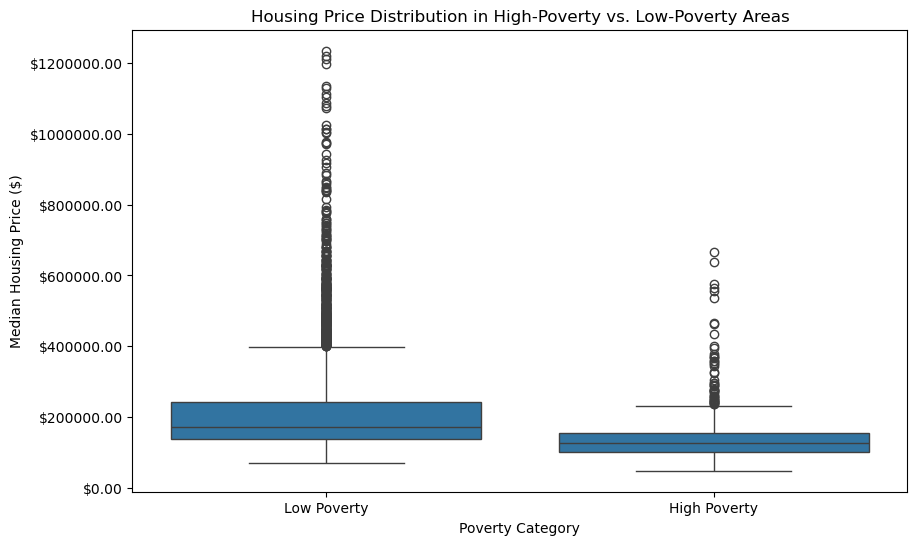

In [17]:
poverty_threshold = 20  
clean_data_df.loc[:, 'Poverty Category'] = np.where(clean_data_df['% People Living in Poverty'] > poverty_threshold, 'High Poverty', 'Low Poverty')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Poverty Category', y='Median House Price ($)', data=clean_data_df)
plt.title('Housing Price Distribution in High-Poverty vs. Low-Poverty Areas')
plt.xlabel('Poverty Category')
plt.ylabel('Median Housing Price ($)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.2f'))
plt.show()


Region
Urban    5373
Rural    2074
Name: count, dtype: int64


<Axes: xlabel='% People Living in Poverty', ylabel='Median House Price ($)'>

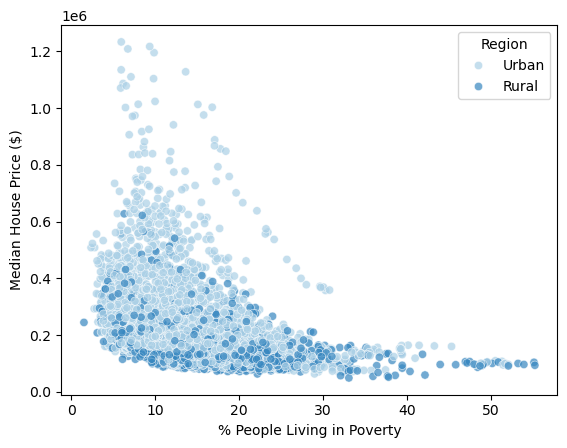

In [18]:
# Regions Classification as Urban or Rural based on population
clean_data_df.loc[:, 'Region'] = np.where(clean_data_df['Total Population'] >= 100000, 'Urban', 'Rural')
urban_df = clean_data_df[clean_data_df['Region'] == 'Urban']
rural_df = clean_data_df[clean_data_df['Region'] == 'Rural']

# data for regression
X = clean_data_df[['% People Living in Poverty']]  
X = sm.add_constant(X)    
y = clean_data_df['Median House Price ($)']  

print(clean_data_df['Region'].value_counts())

sns.scatterplot(x='% People Living in Poverty', y='Median House Price ($)', hue='Region', data=clean_data_df, palette='Blues',alpha=0.7)



In [19]:
# Creating 'Region' column based on 'Total Population'
clean_data_df.loc[:, 'Region'] = np.where(clean_data_df['Total Population'] >= 100000, 'Urban', 'Rural')

urban_df = clean_data_df[clean_data_df['Region'] == 'Urban']
rural_df = clean_data_df[clean_data_df['Region'] == 'Rural']

# Calculate summary statistics
urban_summary = urban_df[['Median House Price ($)', '% People Living in Poverty']].describe()
rural_summary = rural_df[['Median House Price ($)', '% People Living in Poverty']].describe()



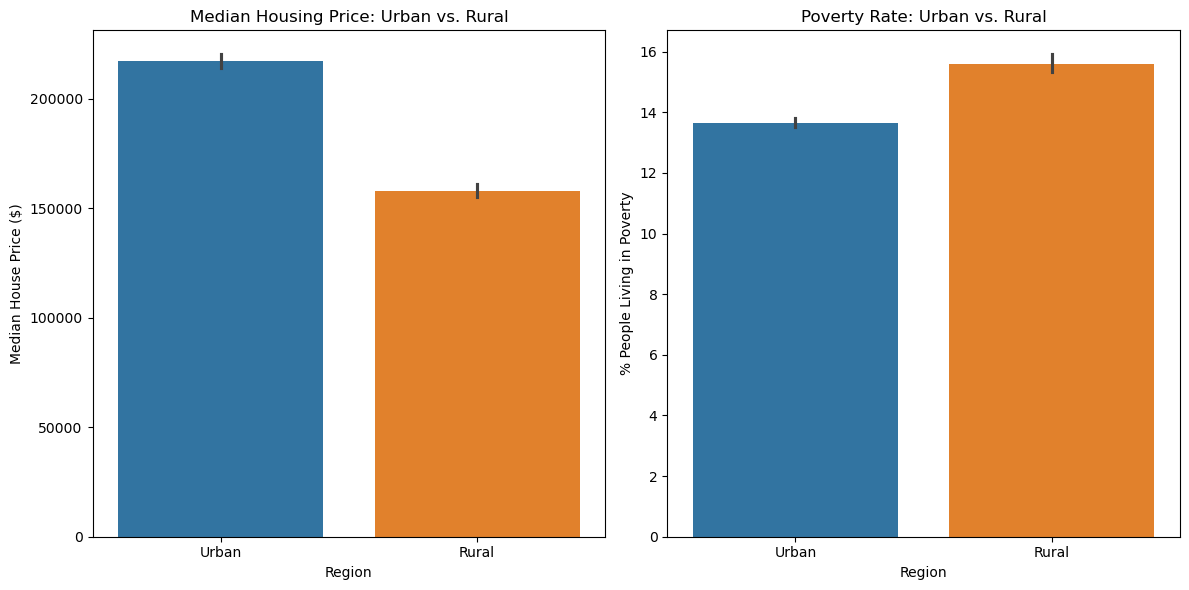

In [20]:
# Bar plot comparing Housing Price and Poverty Rate between Urban and Rural areas
plt.figure(figsize=(12, 6))

# Plot Housing Price comparison
plt.subplot(1, 2, 1)
sns.barplot(x="Region", 
            y="Median House Price ($)", 
            hue="Region",  
            data=clean_data_df)
plt.title("Median Housing Price: Urban vs. Rural")

# Plot Poverty Rate comparison
plt.subplot(1, 2, 2)
sns.barplot(x="Region", 
            y="% People Living in Poverty", 
            hue="Region", 
            data=clean_data_df)
plt.title("Poverty Rate: Urban vs. Rural")

plt.tight_layout()
plt.show()


In [21]:
clean_data_df

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,...,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree,Combined FIPS,Poverty Category,Region
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,...,01,003,2011,4.784498,91.068052,12.972038,12.937761,00301,Low Poverty,Urban
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,...,01,015,2011,5.037336,87.107572,20.663514,6.579115,01501,High Poverty,Urban
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,...,01,043,2011,4.392857,90.176552,18.302374,6.056919,04301,Low Poverty,Rural
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,...,01,049,2011,4.461380,87.818876,18.484063,3.453590,04901,Low Poverty,Rural
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,...,01,051,2011,3.860309,89.063651,12.161623,10.402685,05101,Low Poverty,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,7574,...,72,137,2019,5.162916,87.780156,38.193911,14.475367,13772,High Poverty,Rural
7443,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,16578,...,72,025,2019,4.462651,90.249694,38.401843,16.798549,02572,High Poverty,Urban
7444,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,61677,...,72,127,2019,3.464733,82.202677,39.230815,17.496491,12772,High Poverty,Urban
7445,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,10768,...,72,061,2019,3.654264,91.732293,22.813157,21.649866,06172,High Poverty,Rural
